# Multi-Dimensional Data input for Stock Prediction

As seen in the other notebooks, we can predict the stock market price of a company with an OK accuracy rate, it gives us the basic shape of the stock, but fails when the trend changes drastically.

In order to fix this, we can add a higher dropout level in order to reduce the overfitting for the training data, but we can also add more dimensions of data to further improve the models ability to predict the market.

### Data Types

We'll use the `pandas_datareader` python module to gather historical stock data from Yahoo! instead of downloading the past 10 years from NASDAQ manually. We'll be able to access this data using a standard Pandas Dataframe.

We can use not only the closing price for the day, but also the opening, high, and low, and any other data we may want.

In [237]:
# dependencies
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, Callback
from sklearn.cross_validation import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import requests
import pandas_datareader as web
import datetime

In [47]:
# HYPER PARAMETERS
look_back = 7
epochs = 100
batch_size = 32

In [9]:
# get stock data for Boeing, Inc. (BA)

# specify the start date, which will be in 2008
start = datetime.datetime(2008,1,1)
# specify the end date, which should be today
end = datetime.datetime.now()

data = web.DataReader("BA", 'yahoo', start, end)
print(data.head())

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2008-01-02  87.570000  87.839996  86.000000  86.620003  66.612892  4303000
2008-01-03  87.070000  87.639999  86.739998  86.980003  66.889755  3427900
2008-01-04  86.320000  87.160004  85.690002  85.820000  65.997665  5393400
2008-01-07  86.250000  86.300003  82.169998  82.870003  63.729050  9961800
2008-01-08  83.110001  83.370003  79.650002  79.910004  61.452744  9810600


In [216]:
# get the data from the response
closing = data.Close.values.astype('float32')
opening = data.Open.values.astype('float32')
high = data.High.values.astype('float32')
low = data.Low.values.astype('float32')
adj_close = data["Adj Close"].values.astype('float32')
volume = data.Volume.values.astype('float32')
# reassign our data into column vector format so we can loop through them easily
closing = closing.reshape(len(closing), 1)
opening = opening.reshape(len(opening), 1)
high = high.reshape(len(high), 1)
low = low.reshape(len(low), 1)
adj_close = adj_close.reshape(len(adj_close), 1)
volume = volume.reshape(len(volume), 1)
# create an empty prices tensor that we will populate with our data
# our tensor will have the shape (closing, opening, high, low, adjusted_close, volume) * len(data)
prices = np.zeros((len(data), 6))
print("Prices Shape:", prices.shape)

# reassign the values to the tensor

for index, val in enumerate(prices):
    prices[index, 0] = closing[index]
    prices[index, 1] = opening[index]
    prices[index, 2] = high[index]
    prices[index, 3] = low[index]
    prices[index, 4] = adj_close[index]
    prices[index, 5] = volume[index]
print("Prices:", prices)

Prices Shape: (2536, 6)
Prices: [[8.66200027e+01 8.75699997e+01 8.78399963e+01 8.60000000e+01
  6.66128922e+01 4.30300000e+06]
 [8.69800034e+01 8.70699997e+01 8.76399994e+01 8.67399979e+01
  6.68897552e+01 3.42790000e+06]
 [8.58199997e+01 8.63199997e+01 8.71600037e+01 8.56900024e+01
  6.59976654e+01 5.39340000e+06]
 ...
 [3.34690002e+02 3.36200012e+02 3.38989990e+02 3.34140015e+02
  3.34690002e+02 4.20540000e+06]
 [3.43109985e+02 3.36209991e+02 3.43619995e+02 3.35299988e+02
  3.43109985e+02 4.59100000e+06]
 [3.42799988e+02 3.44329987e+02 3.45980011e+02 3.41519989e+02
  3.42799988e+02 5.28084000e+05]]


### Data Normalization

We need to normalize our values (squish them between 0 and 1) so our data is all on the same "playing field". We'll use a MinMaxScaler to do that with a feature range of (0,1)

In [217]:
normalizer = MinMaxScaler(feature_range=(0,1))
# normalize our prices tensor
prices = normalizer.fit_transform(prices)

### Training and Testing Data

When training we want a high accuracy rate, but we also want a high accuracy rate for our testing. Therefore we want the RMSE for both training and testing to be as low as possible. We need to be careful when determining how much data to use for training, and how much to use for testing, because we don't want the model too overfit to the training, but at the same time we don't want the model to be underfit.

In [218]:
# split the training testing data 60%, 40%

trainingSize = int(len(prices) * 0.6)

training, testing = prices[0:trainingSize, :], prices[trainingSize:len(prices), :]
print("Training Shape:", training.shape)
print("Testing Shape:", testing.shape)

Training Shape: (1521, 6)
Testing Shape: (1015, 6)


In [219]:
# creating a dataset for multidimensional data
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for index in range(len(dataset)-look_back-1):
        a = dataset[index:(index+look_back), :]
        dataX.append(a)
        dataY.append(dataset[index + look_back, :])
    return np.array(dataX), np.array(dataY)

In [220]:
trainX, trainY = create_dataset(training, look_back)

testX, testY = create_dataset(testing, look_back)


In [221]:
def train_reshape(trainX, testX):
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
    return trainX, testX

print(trainX.shape)
print(testX.shape)
trainX, testX = train_reshape(trainX, testX)

(1513, 7, 6)
(1007, 7, 6)


In [226]:
# create the model

model = Sequential()

model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(look_back, 6)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(32, return_sequences=False)))

model.add(Dense(units=6))

# compile with mse and adam optimizer
model.compile(loss='mse', optimizer='adam')

In [227]:
# fit the model
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size)

Epoch 1/100
1513/1513 [==============================] - 9s 6ms/step - loss: 0.0028
Epoch 2/100
1513/1513 [==============================] - 1s 653us/step - loss: 7.7521e-04
Epoch 3/100
1513/1513 [==============================] - 1s 657us/step - loss: 7.2505e-04
Epoch 4/100
1513/1513 [==============================] - 1s 649us/step - loss: 7.0847e-04
Epoch 5/100
1513/1513 [==============================] - 1s 648us/step - loss: 6.9639e-04
Epoch 6/100
1513/1513 [==============================] - 1s 650us/step - loss: 7.0770e-04
Epoch 7/100
1513/1513 [==============================] - 1s 650us/step - loss: 6.7476e-04
Epoch 8/100
1513/1513 [==============================] - 1s 642us/step - loss: 6.6084e-04
Epoch 9/100
1513/1513 [==============================] - 1s 649us/step - loss: 6.5657e-04
Epoch 10/100
1513/1513 [==============================] - 1s 652us/step - loss: 6.5467e-04
Epoch 11/100
1513/1513 [==============================] - 1s 653us/step - loss: 6.5565e-04
Epoch 12/100
1

Epoch 91/100
1513/1513 [==============================] - 1s 654us/step - loss: 5.6820e-04
Epoch 92/100
1513/1513 [==============================] - 1s 660us/step - loss: 5.6300e-04
Epoch 93/100
1513/1513 [==============================] - 1s 658us/step - loss: 5.7526e-04
Epoch 94/100
1513/1513 [==============================] - 1s 658us/step - loss: 5.5701e-04
Epoch 95/100
1513/1513 [==============================] - 1s 665us/step - loss: 5.7097e-04
Epoch 96/100
1513/1513 [==============================] - 1s 659us/step - loss: 5.5795e-04
Epoch 97/100
1513/1513 [==============================] - 1s 658us/step - loss: 5.6010e-04
Epoch 98/100
1513/1513 [==============================] - 1s 656us/step - loss: 5.6298e-04
Epoch 99/100
1513/1513 [==============================] - 1s 661us/step - loss: 5.5579e-04
Epoch 100/100
1513/1513 [==============================] - 1s 655us/step - loss: 5.5979e-04


In [228]:
# predict some values
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

In [229]:
# reverse the predictions for RMSE
trainPredictions = normalizer.inverse_transform(trainPredictions)
trainY = normalizer.inverse_transform(trainY)
testPredictions = normalizer.inverse_transform(testPredictions)
testY = normalizer.inverse_transform(testY)

In [236]:
# calculate the Root Mean Squared Error

trainingScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredictions[:, 0]))
testingScore = math.sqrt(mean_squared_error(testY[:, 0], testPredictions[:, 0]))

print("Training Score: %.5f RMSE" % (trainingScore))
print("Testing Score: %.5f RMSE" % (testingScore))

Training Score: 1.70754 RMSE
Testing Score: 32.50565 RMSE


In [231]:
# reconvert the prices into their unnormalized form
prices = normalizer.inverse_transform(prices)
prices.shape

(2536, 6)

In [232]:
# format the data for proper display
trainingPlot = np.empty_like(prices)
trainingPlot[:, :] = np.nan
trainingPlot[look_back:len(trainPredictions)+look_back, :] = trainPredictions


testingPlot = np.empty_like(prices)
testingPlot[:, :] = np.nan
testingPlot[len(trainPredictions)+(look_back*2)+1:len(prices)-1, :] = testPredictions

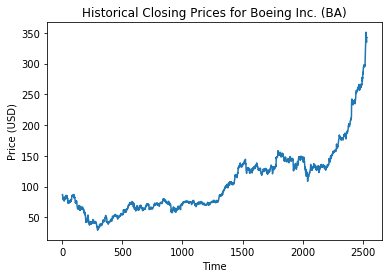

In [233]:
# plot our original data
plt.plot(prices[:, 0])
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Historical Closing Prices for Boeing Inc. (BA)")
plt.show()

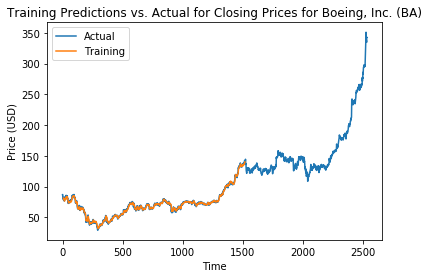

In [234]:
plt.plot(prices[:, 0], label="Actual")
plt.plot(trainingPlot[:, 0], label="Training")
plt.title("Training Predictions vs. Actual for Closing Prices for Boeing, Inc. (BA)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

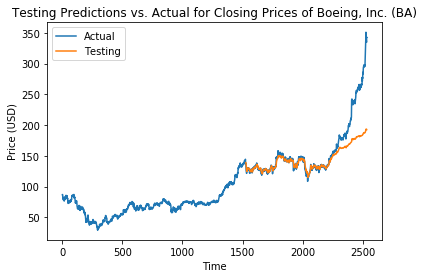

In [235]:
plt.plot(prices[:, 0], label="Actual")
plt.plot(testingPlot[:, 0], label="Testing")
plt.title("Testing Predictions vs. Actual for Closing Prices of Boeing, Inc. (BA)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

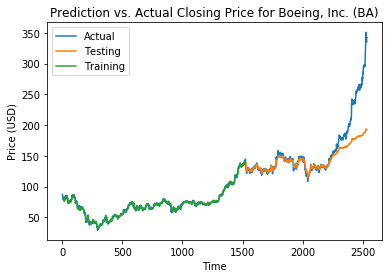

In [238]:
plt.plot(prices[:, 0], label="Actual")
plt.plot(testingPlot[:, 0], label="Testing")
plt.plot(trainingPlot[:, 0], label="Training")
plt.title("Prediction vs. Actual Closing Price for Boeing, Inc. (BA)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### Accuracy

By adding more dimensions to our data, we were able to improve the accuracy of the model, allowing the model to start to predict the upward trend of the price hike increase. Without this extra data, the model predicted a slightly downward trend. We can further improve the accuracy by adding sentiment analysis, or data from competitors, such as Airbus. We can also add sales, and company profit as well as politics around the space, and much more.

To further improve the general accuracy when testing, we can perform hyperparameter optimization so the model doesn't become too overfit on the training data.